# **Part 1: Handwritten digit recognition using MNIST and Convolutional Neural Networks (CNNs)**

In these exercises, we will use PyTorch to implement Deep Learning methods that perform pattern recognition. In particular, we will consider a Convolutional Neural Network (CNN) to recognize MNIST's handwritten digits in this article.

We will see three ways of using CNNs to classify MNIST data:


1.   Training a custom model for feature extraction and classification.
2.   Pretrained CNN as a feature extractor, combined with a shallow classifier.
3.   Fine tuning CNN to perform both feature extraction and classification.


In [2]:
from torchvision import models
from torchvision import transforms
from torchvision import datasets
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import time
import copy

In [16]:
batch_sizeP = 300 # Each Batch is 300
numWorkersP = 2 # We use 2 Threads
numClassesMNIST = 10 # MNIST classes are "0" through "9"

In [4]:
# Try to use CUDA
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
if cuda:
    torch.cuda.empty_cache()
print("Cuda is {0}".format(cuda))

Cuda is False


In [5]:
# Build a Transformer to Normalize Data
# Mean and Stddev for MNIST Dataset are known (0.13, 0.31)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [7]:
# Download the Dataset (directly via datasets) and build DataLoaders

train_folder = datasets.MNIST('./files/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_folder, batch_size=batch_sizeP, num_workers=numWorkersP, shuffle=True)

test_folder = datasets.MNIST('./files/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_folder, batch_size=batch_sizeP, num_workers=numWorkersP, shuffle=True)

In [20]:
dataset_sizes = dict(
    train=len(train_folder),
    test=len(test_folder)
)

numBatches = dict(
    train=np.round(dataset_sizes['train'] / batch_sizeP),
    test=np.round(dataset_sizes['test'] / batch_sizeP)
)

dataset_sizes, numBatches

({'train': 60000, 'test': 10000},
 {'train': np.float64(200.0), 'test': np.float64(33.0)})

In [21]:
# Simple custom Module

class AngeloNet(nn.Module):
    def __init__(self, numClasses):
        super(AngeloNet, self).__init__()

        self.flat = nn.Flatten()

        self.features = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5), # Convolutional Layer with 1 IN and 10 OUT. Filter has size 5x5
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential( # This is the Classifier (MLP-like)
            nn.Linear(320, 50),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(50, numClasses)
        )

    def forward(self, x): # Defines order of layers (Features --> Classifier)
        x = self.features(x)
        # x = x.view(-1, 320)
        x = self.flat(x)
        x = self.classifier(x)
        return x

In [29]:
currentModel = AngeloNet(numClassesMNIST)
if cuda:
  currentModel.to('cuda')

lr = 0.01
momentum = 0.5 # Needed for the optimizer
num_epochs = 5

criterion = nn.CrossEntropyLoss() # Loss Function
optimizer_ft = optim.SGD( # Stochastic Gradient Descent
    currentModel.parameters(),
    lr=lr,
    momentum=momentum
)

In [30]:
def train_model(model, criterion, optimizer, num_epochs, dataset_sizes, dataloaders, batch_sizeP, cuda):

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    numBatches = np.round(dataset_sizes['train'] / batch_sizeP)

    model.train()  # Set model to training mode (e.g. for Dropout)

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data using the DataLoader
        for batch_idx, (inputs, labels) in enumerate(dataloaders):

            if cuda:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

            if batch_idx % 10 == 0:
                pass

            optimizer.zero_grad()  # zero the parameter gradients

            outputs = model(inputs) # calls forward
            _, preds = torch.max(outputs, 1) # Returns the index of the label which has the maximum value
            loss = criterion(outputs, labels) # computes error

            # Back-propagation
            loss.backward()
            optimizer.step()

            # Training stats
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        print('\t{} Loss: {:.4f} Acc: {:.4f}'.format(
            'train', epoch_loss, epoch_acc))

        # Deep Copy the Model (to keep the best model aside)
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    print('Best acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    return model

In [31]:
currentModel = train_model(
    currentModel,
    criterion,
    optimizer_ft,
    num_epochs,
    dataset_sizes,
    train_loader,
    batch_sizeP,
    cuda
)

Epoch 1/5
	train Loss: 1.2843 Acc: 0.5687
Epoch 2/5
	train Loss: 0.5140 Acc: 0.8397
Epoch 3/5
	train Loss: 0.3894 Acc: 0.8796
Epoch 4/5
	train Loss: 0.3327 Acc: 0.8985
Epoch 5/5
	train Loss: 0.2967 Acc: 0.9105

Training complete in 1m 17s
Best acc: 0.910550


In [32]:
# Now we can show what we predicted

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloaders, cuda, class_names, num_images=6):

    was_training = model.training
    model.eval()

    images_so_far = 0

    fig = plt.figure()

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(dataloaders):

            if cuda:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):

                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

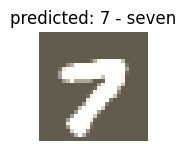

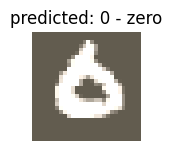

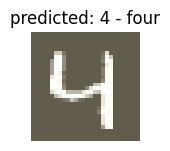

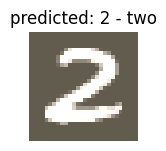

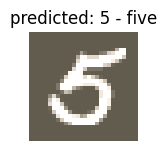

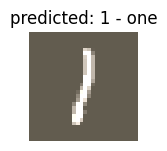

In [36]:
# visualize some outputs
visualize_model(currentModel, test_loader, cuda, train_folder.classes, num_images=6)

In [34]:
2def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

In [39]:
# Eval mode
currentModel.eval()

# init
predALL_test = torch.empty(dataset_sizes['test'])
labelsALL_test = torch.empty(dataset_sizes['test'])
numBatches = np.round(dataset_sizes['test'] / batch_sizeP)

with torch.no_grad():
        for batch_num, (x, y) in enumerate(test_loader):

            # display
            if batch_num % 10 == 0:
                print("Batch n. {0} / {1}".format(batch_num, int(numBatches)))

            # extract features
            if cuda:
                x = x.to('cuda')
                y = y.to('cuda')

            # stack
            indStart = batch_num * batch_sizeP
            indEnd = indStart + batch_sizeP

            # predict
            outputs = currentModel(x)
            _, preds = torch.max(outputs, 1)

            predALL_test[indStart:indEnd] = preds
            labelsALL_test[indStart:indEnd] = y

# confusion matrix
CM = confusion_matrix(labelsALL_test, predALL_test)
accuracyResult = accuracy(CM)

print("Accuracy: {0:.2f}%".format(accuracyResult * 100))
print("Confusion Matrix:")
CM

Batch n. 0 / 33
Batch n. 10 / 33
Batch n. 20 / 33
Batch n. 30 / 33
Accuracy: 96.66%
Confusion Matrix:


array([[ 972,    0,    1,    0,    0,    1,    2,    1,    3,    0],
       [   0, 1121,    4,    2,    0,    1,    2,    1,    4,    0],
       [  13,    2,  991,    5,    2,    0,    1,   13,    4,    1],
       [   0,    0,   12,  966,    0,   12,    0,    8,   10,    2],
       [   1,    1,    1,    0,  954,    0,    9,    1,    2,   13],
       [   4,    1,    0,    9,    0,  866,    6,    2,    3,    1],
       [  12,    3,    1,    0,    5,    4,  931,    0,    2,    0],
       [   2,    5,   19,    2,    0,    0,    0,  992,    2,    6],
       [   7,    2,    4,    2,    2,    4,    4,    6,  935,    8],
       [   9,    6,    4,    7,   16,    6,    0,   12,   11,  938]])

# **Part 2: Pretrained CNN as a Feature Extractor**

In this tutorial, you will learn how to use a convolutional neural network for image classification using transfer learning.

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

In particular, in this tutorial we will load an AlexNet pretrained on the ImageNet database and use it as a feature extractor for the MNIST database.